In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(os.path.join('..', '..', 'data', 'tidy_Stroke_Vital_Sign.csv'))
data_x = data.drop(['UID', 'Hospital_ID', 'SurvivalWeeks', 'admission_date',
                    'discharge_date', 'death_date', 'Mortality', 'CVDeath'], axis=1)
categorical_ix = [0, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17]
categorical_columns = data_x.columns[categorical_ix].values
data_x_one_hot = pd.get_dummies(data_x, columns=categorical_columns)

data_y = data[['Mortality', 'SurvivalWeeks']]
data_y['Mortality'] = data_y['Mortality'].astype(bool)
data_y = np.array(list(data_y.to_records(index=False)))

<ipython-input-2-99102b60bd71>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_y['Mortality'] = data_y['Mortality'].astype(bool)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data_x_one_hot, data_y, test_size=0.25, random_state=369)

In [4]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=369)

In [5]:
rsf.fit(X_train, y_train)

print(rsf.score(X_test, y_test))

0.8094758199305002


In [17]:
demo_x = pd.concat([X_test[X_test['AF_1.0'] == 1].sample(n=3, random_state=369),
                    X_test[X_test['AF_1.0'] == 0].sample(n=3, random_state=486)])
demo_x['AF_1.0']

2221     1
12857    1
4072     1
11833    0
3257     0
13174    0
Name: AF_1.0, dtype: uint8

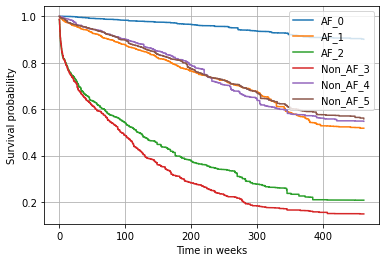

In [13]:
surv = rsf.predict_survival_function(demo_x, return_array=True)

for i, s in enumerate(surv):
    if i < 3:
        plt.step(rsf.event_times_, s, where="post", label='AF_'+str(i))
    else:
        plt.step(rsf.event_times_, s, where="post", label='Non_AF_'+str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in weeks")
plt.legend()
plt.grid(True)

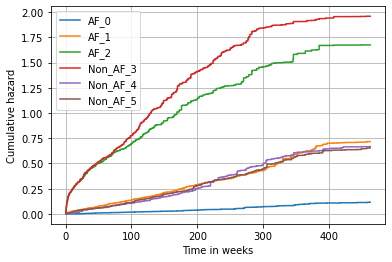

In [18]:
surv = rsf.predict_cumulative_hazard_function(demo_x, return_array=True)

for i, s in enumerate(surv):
    if i < 3:
        plt.step(rsf.event_times_, s, where="post", label='AF_'+str(i))
    else:
        plt.step(rsf.event_times_, s, where="post", label='Non_AF_'+str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in weeks")
plt.legend()
plt.grid(True)

In [19]:
rsf.predict(demo_x)

array([  41.95444568,  302.50449428, 1190.87449934, 1416.55666457,
        283.32324777,  285.00854413])

In [8]:
import eli5
from eli5.sklearn import PermutationImportance
feature_names = data_x_one_hot.columns.values
perm = PermutationImportance(rsf, n_iter=15, random_state=369)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.0419 ± 0.0034,Age
0.0075 ± 0.0043,V
0.0054 ± 0.0035,MPsum
0.0054 ± 0.0019,Cancer before adm_1.0
0.0047 ± 0.0019,Cancer before adm_0.0
0.0047 ± 0.0018,CHOL
0.0043 ± 0.0016,ALT
0.0041 ± 0.0030,Mean HR
0.0032 ± 0.0024,NG_1.0
0.0032 ± 0.0033,NG_0.0
